In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import taichi as ti
ti.reset()

[Taichi] version 1.7.0, llvm 15.0.1, commit 2fd24490, win, python 3.10.13


In [5]:
import taichi as ti
import numpy as np
import math
from engine.mpm_solver import MPMSolver
import argparse
import os




out_dir = 'out_jupyter'
ti.reset()
ti.init(arch=ti.cuda)  # Try to run on GPU

gui = ti.GUI("Taichi Elements", res=512, background_color=0x112F41)

mpm = MPMSolver(res=(256, 256), E_scale=0.001, use_g2p2g=False)
mpm.set_gravity([0, 0])

E1 = 1e6
E2 = 1e3


mpm.add_cube(
    lower_corner=[0.45,0.45],
    cube_size=[0.1,0.1],
    velocity=[0, 0],
    sample_density=0.5,
    material=mpm.material_elastic,
    E=E1,
    nu=0.2
)
for frame in range(10):
    mpm.step(8e-3, print_stat=False)
    particles = mpm.particle_info()
    print(mpm.fan_center, mpm.t, mpm.omega)
    gui.circles(particles['position'], radius=1.5, color=particles['color'])
    gui.show(f'{out_dir}/{frame:06d}.png')

[Taichi] Starting on arch=cuda
[0. 0.] 0.008000000000000018 0.0
[0. 0.] 0.01599999999999917 0.0
[0. 0.] 0.023999999999998325 0.0
[0. 0.] 0.03199999999999748 0.0
[0. 0.] 0.039999999999996635 0.0
[0. 0.] 0.04799999999999579 0.0
[0. 0.] 0.05599999999999494 0.0
[0. 0.] 0.06399999999999544 0.0
[0. 0.] 0.0720000000000017 0.0
[0. 0.] 0.08000000000000797 0.0


: 

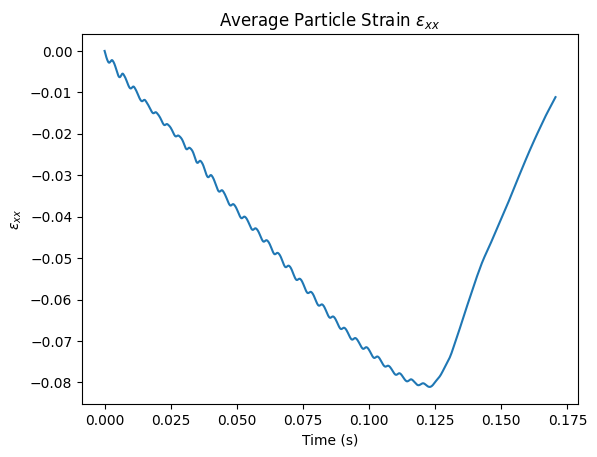

In [19]:
import numpy as np
import matplotlib.pyplot as plt
x_np = np.load('x_np.npy')
grid_v_in = np.load('grid_v_in.npy')
grid_v_out = np.load('grid_v_out.npy')
strain = np.load('strain.npy')
target_strain = np.load('target_strain.npy')
plt.plot(np.arange(target_strain.shape[0])*2e-2/120, np.mean(target_strain, axis=1)[:,0,0])
# plt.plot(np.arange(target_strain.shape[0])*2e-2/120, np.mean(target_strain, axis=1)[:,0,0])
plt.title('Average Particle Strain $\epsilon_{xx}$')
plt.xlabel('Time (s)')
plt.ylabel('$\epsilon_{xx}$')
plt.show()


In [22]:
target_strain_np = np.load('x_simple.npy')
target_strain_np.shape

(1024, 3600, 2)

In [50]:
strain.shape

(1024, 3600, 2, 2)

In [72]:
x_np[:,:,1].max()

0.9847796

In [85]:
grid_v_out[0].min()

-0.0

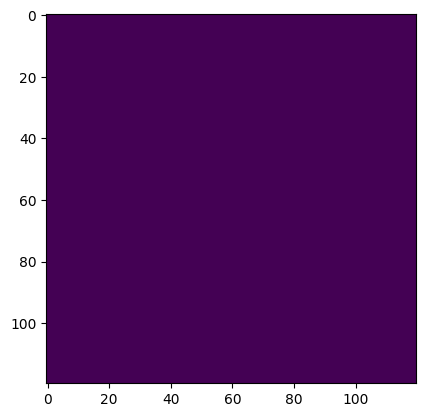

In [63]:
gvs = grid_v_in[-1]
plt.imshow(gvs[:,:,0])

In [38]:

ti.init()
real = ti.f32
dim = 2
N = 60
max_steps = 1024
n_particles = N * N
n_grid = 120
dx = 1 / n_grid
x = ti.Vector.field(dim,
                    dtype=real,
                    shape=(max_steps, n_particles),
                    needs_grad=True)

for i in range(N):
    for j in range(N):
        x[0, i * N + j] = [dx * (i * 0.7 + 10), dx * (j * 0.7 + 25)]
        print([dx * (i * 0.7 + 10), dx * (j * 0.7 + 25)])



[Taichi] Starting on arch=x64
[0.08333333333333333, 0.20833333333333334]
[0.08333333333333333, 0.21416666666666664]
[0.08333333333333333, 0.21999999999999997]
[0.08333333333333333, 0.22583333333333333]
[0.08333333333333333, 0.23166666666666666]
[0.08333333333333333, 0.2375]
[0.08333333333333333, 0.24333333333333332]
[0.08333333333333333, 0.24916666666666665]
[0.08333333333333333, 0.255]
[0.08333333333333333, 0.26083333333333336]
[0.08333333333333333, 0.26666666666666666]
[0.08333333333333333, 0.2725]
[0.08333333333333333, 0.2783333333333333]
[0.08333333333333333, 0.2841666666666667]
[0.08333333333333333, 0.29]
[0.08333333333333333, 0.29583333333333334]
[0.08333333333333333, 0.3016666666666667]
[0.08333333333333333, 0.3075]
[0.08333333333333333, 0.31333333333333335]
[0.08333333333333333, 0.31916666666666665]
[0.08333333333333333, 0.325]
[0.08333333333333333, 0.33083333333333337]
[0.08333333333333333, 0.33666666666666667]
[0.08333333333333333, 0.34249999999999997]
[0.08333333333333333, 0

In [3]:
ti.reset()

In [3]:
import taichi as ti
import numpy as np
import engine.utils as utils


# external forces
velocity = 4
frequency = 5
node_x_locs = np.arange(5)
xvalues, fxvalues = utils.rolling_gaussian_generator(velocity, frequency, node_x_locs, resolution=5)


ti.init(arch=ti.cuda)


dim = 2
num_nodes = 9
t_intervals = 5

node_ids_fext = range(5)

f_ext = ti.Vector.field(t_intervals, dtype=ti.f32, shape=(num_nodes,dim+1))


for i, node in enumerate(node_ids_fext):
    f_ext[node,0] = xvalues[i]
    f_ext[node,2] = fxvalues


print(f_ext[2,0])
print(f_ext[2,2])



utils.interpolate(-0.1, f_ext[2,0], f_ext[2,2])

[Taichi] Starting on arch=cuda
[-0.5        -0.5        -0.1         0.30000001  0.69999999]
[0.00000000e+00 2.01636235e-10 3.23329004e-04 4.09432918e-01
 4.09432918e-01]


0.0003233305285110086

In [8]:
import engine.utils as utils
import numpy as np
import taichi as ti

ti.reset()
ti.init()
real = ti.f32
dim = 2
size=1
N= 60
n_particles = N * N
n_grid = 120
dx = 1 / n_grid
inv_dx = 1 / dx
dt_scale = 1
dt = 2e-2 * dx / size * dt_scale
max_steps = 1024
velocity = 4
frequency = 5
n_grid = 120
node_x_locs = np.arange(0, 1, 1 / n_grid)

time_to_center = node_x_locs / velocity
t_steps = np.arange(max_steps) * dt

t_steps_n = np.array([t_steps - time for time in time_to_center])
t_steps_n = np.stack(t_steps_n, axis=1)

node_ids_fext_x = range(n_grid)

_, _, e, = utils.gausspulse(t_steps_n)
e
t_steps_n
grid_v_ext = ti.Vector.field(dim,
                            dtype=real,
                            shape=(max_steps, n_grid, n_grid),
                            needs_grad=True)

print('loop')
for t in range(max_steps):
    for node in node_ids_fext_x:
        grid_v_ext[t, node, -1] = [0, 0.5 * e[t, node]]

[Taichi] Starting on arch=x64
loop


In [7]:
0.5 * e[0, 5]

1.207050302249221e-36

In [20]:
ti.init()
a = ti.field(ti.f32, shape=())
a[None] = 0.5

[Taichi] Starting on arch=x64


1.0

(1024, 3600, 2, 2)

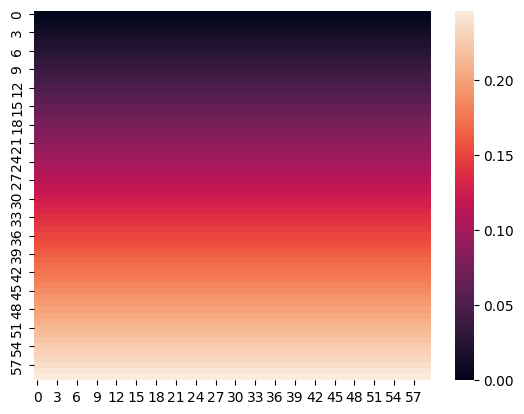

In [45]:
x1 = x_grav[0, :]
arr = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        arr[i, j] = 3 * i + j
sns.heatmap(einops.rearrange(x1, '(x y) c -> y x c', x=60)[:, :, 1])
# sns.heatmap(arr)

einops.rearrange(x1, '(x y) c -> y x c', x=60)[:, :, 1][:, 0]
strain_grav.shape

<Axes: >

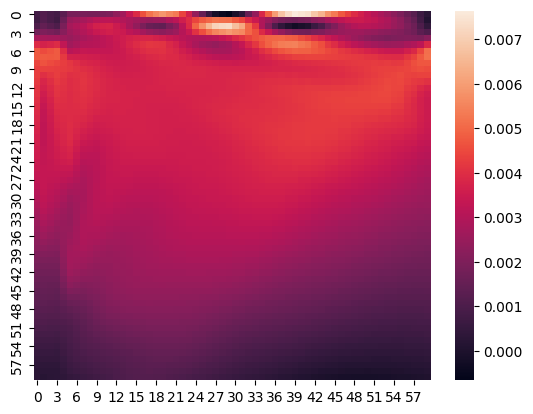

In [54]:
data = einops.rearrange(strain_grav[100, :, 0, 0], '(x y) -> y x', x=60)
sns.heatmap(data)

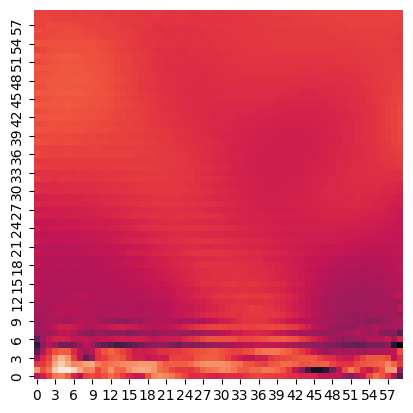

In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
import einops

strain_grav = np.load("strain_grav.npy")
x_grav = np.load("x_grav.npy")
strain_g_xx = strain_grav[:, :, 0, 0]

fig = plt.figure()
def init():
    sns.heatmap(np.zeros((10, 10)), vmax=.8, square=True, cbar=False)

def animate(i):
    data = einops.rearrange(strain_grav[i, :, 1, 1], '(x y) -> y x', x=60)
    ax = sns.heatmap(data, cbar=False)
    ax.invert_yaxis()


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=10, repeat = False)

savefile = r"test3y.gif"
pillowwriter = animation.PillowWriter(fps=20)
anim.save(savefile, writer=pillowwriter)

plt.show()